In [ ]:
# %matplotlib widget
from micromlgen import port

import os
from platform import python_version
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import warnings
from scipy.stats import f_oneway

warnings.filterwarnings("ignore")
assert python_version() == "3.10.15"
assert np.__version__ == "2.0.2"
assert pd.__version__ == "2.2.3"

 
#Function to extract the training data
def get_training(original_path):
    
    # Load the training data csv file into a dataframe. 
    df = pd.read_csv(os.path.join(original_path,'train.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'train_extracted')):
        os.makedirs(os.path.join(original_path,'train_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):    
        d,r = librosa.load(os.path.join(original_path,'train',str(audio_files[i])),mono=True)
        np.save(os.path.join(original_path, 'train_extracted',str(audio_files[i])+'.npy'),d)   
            
#Function to extract the testing data
def get_testing(original_path):

    # Load the test data csv file into a dataframe.
    df = pd.read_csv(os.path.join(original_path,'test_idx.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'test_extracted')):
        os.makedirs(os.path.join(original_path,'test_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):   
        d,r = librosa.load(os.path.join(original_path,'test',str(audio_files[i])),mono=True)
        np.save(os.path.join(original_path, 'test_extracted',str(audio_files[i])+'.npy'),d)      
          
#Funtion to retrieve the labels of training data
def get_labels(original_path,csv_file):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Return the labels.
  labels = np.array(df['keyword'])

  return labels

#Funtion to get the features of the data
def get_all_features(original_path, csv_file, extracted_folder):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))
  df.fillna(0, inplace=True)

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  all_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate Root Mean Square Error.
    rmse= librosa.feature.rms(y=audio_file_data, frame_length=441)

    # Calculate Zero Crossing Rate.
    zcr =librosa.feature.zero_crossing_rate(audio_file_data, frame_length=441)

    # Calculate and append statistic features for all the above data features.
    # addList = np.concatenate((np.mean(mfcc_data, axis=1),np.median(mfcc_data,axis=1),np.std(mfcc_data, axis=1),skew(mfcc_data, axis=1),kurtosis(mfcc_data, axis=1),np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(chroma_stft)),np.atleast_1d(np.median(chroma_stft)),np.atleast_1d(np.std(chroma_stft)),np.atleast_1d(skew(chroma_stft)),np.atleast_1d(kurtosis(chroma_stft)),np.atleast_1d(np.mean(spec_cent)),np.atleast_1d(np.median(spec_cent)),np.atleast_1d(np.std(spec_cent)),np.atleast_1d(skew(spec_cent,axis=1)),np.atleast_1d(kurtosis(spec_cent,axis=1)),np.atleast_1d(np.mean(spec_bw)),np.atleast_1d(np.median(spec_bw)),np.atleast_1d(np.std(spec_bw)),np.atleast_1d(skew(spec_bw,axis=1)),np.atleast_1d(kurtosis(spec_bw,axis=1)),np.atleast_1d(np.mean(rolloff)),np.atleast_1d(np.median(rolloff)),np.atleast_1d(np.std(rolloff)),np.atleast_1d(skew(rolloff,axis=1)),np.atleast_1d(kurtosis(rolloff,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1)),np.amax(mfcc_data, axis=1),np.amin(mfcc_data, axis=1)))
    addList = np.concatenate((np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1))))
    all_features.append(addList)
     

  return all_features

#Function to use Random Forest classifier
def random_forest(X_train,Y_train,X_test):

  # Intialize Random Forest classifier with number of trees as 800.
  random_forest = RandomForestClassifier(n_estimators = 800, class_weight='balanced')

  # Fit Training Dataset.
  random_forest.fit(X_train, Y_train)

  # Predict and return labels.
  return random_forest.predict(X_test)

#Funtion to standardize the features
def standardize_features(X_train,X_test):

  # Initialize standard scalar with zero mean
  sc = StandardScaler(with_mean=False)

  # Fit and transform the Training Dataset.
  X_train= sc.fit_transform(X_train)

  # Transform the testing set.
  X_test = sc.transform(X_test)
  
  return X_train,X_test
#Function to plot the confusion matrix
def plot_confusion_matrix(y_true,y_pred,label_names,classifier):
    
    # Calculate the confusion matrix using the expected and predicted values.
    #confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    # print(y_true)
    # print(y_pred)
    confusion_mat = confusion_matrix(y_true,y_pred,labels=label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(5,4))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputs", fontsize=10)
    plt.ylabel("Actual Outputs", fontsize=10)
    plt.title("Confusion Matrix of "+ classifier + " classifier",fontsize=12)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names)
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='10')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='12')
            
    # Show the plot
    plt.show()
#Function to perform cross validation
def cross_validate(X_train,Y_train,data_rep):

 # Choose classifiers based on the Data Representation.
 if data_rep=="Forest":
    clf = random_forest
    classifier="Random Forest" 
 sc = StandardScaler()
 X_train = sc.fit_transform(X_train)
 


 # Create a Stratified KFold with 5 splits.
 k_fold = StratifiedKFold(n_splits=5,shuffle=True)

 # Create two empty lists to keep track of accuracies for plotting and predictions for confusion matrix.
 accuracies_clf = np.array([])
 predictions_clf = np.array([])
 actual_predictions = np.array([])

 # Split the Dataset and Loop through each fold.
 for train_index, test_index in k_fold.split(X_train,Y_train):

    # Split the Dataset into Training and Validation.
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]    

    # Fit and Predict the current fold using the classifier.
    pred = clf(x_train,y_train,x_test)

    # Append the accuracies and predictions.
    predictions_clf = np.append(predictions_clf,pred)
    actual_predictions = np.append(actual_predictions,y_test)
    accuracies_clf = np.append(accuracies_clf,accuracy_score(pred,y_test))
    
 # Plot the confusion matrix for the classifier.
 plot_confusion_matrix(actual_predictions,predictions_clf,label_names,classifier)
 
 fig2 = plt.figure(figsize=(5,4))  
 # Plot the accuracy of the classifier for different folds
 plt.plot([1,2,3,4,5],accuracies_clf)
 plt.xticks(np.arange(1,5,1))
 plt.xlabel("5-Fold CV")
 plt.ylabel("Accuracy")
 plt.show() 

 # Calculate and print the accuracy range with 99% confidence interval
 accuracy_clf= accuracy_score(predictions_clf,actual_predictions)
 radius_clf = 2.58 * np.sqrt(accuracy_clf*(1-accuracy_clf)/len(predictions_clf))
 accuracy_clf_min =  (accuracy_clf - radius_clf)
 accuracy_clf_max =  (accuracy_clf + radius_clf)

 print('\n\n Accuracy of '+ classifier +' on Validation Dataset is ' + str(accuracy_clf))
 print('\n At 99% Confidence Interval :')
 print('\n The Accuracy of ' + classifier + ' is likely between ' + str(accuracy_clf_min) + ' and ' + str(accuracy_clf_max))




Extract Features

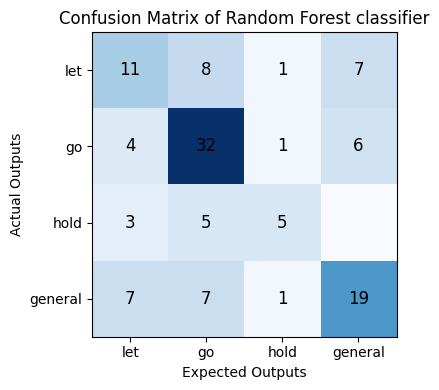

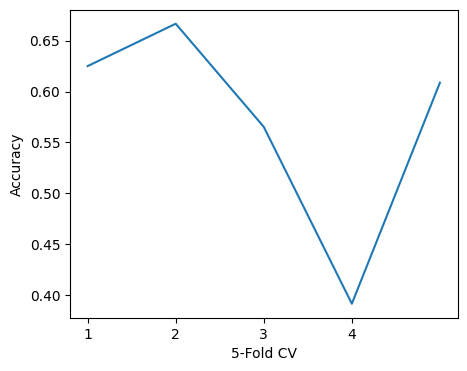



 Accuracy of Random Forest on Validation Dataset is 0.5726495726495726

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.4546546508280741 and 0.6906444944710711


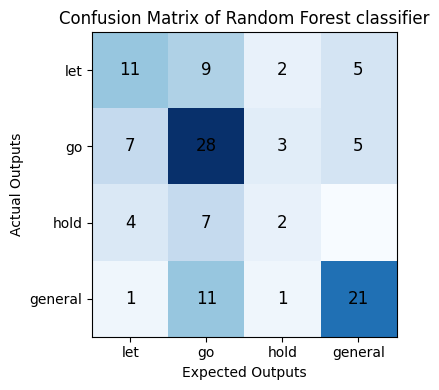

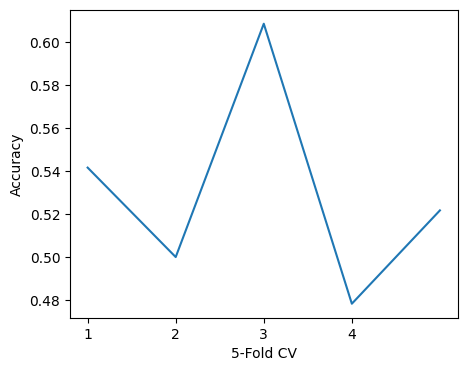



 Accuracy of Random Forest on Validation Dataset is 0.5299145299145299

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.41086762661179005 and 0.6489614332172697


In [4]:
label_names=['let', 'go','hold','general']

# Set the path to the unfiltered dataset
original_path = os.path.join("G:\BioML_Datasets\DatasetV2")
get_training(original_path)
get_testing(original_path)
X_train = get_all_features(original_path,'train.csv','train_extracted')
X_test = get_all_features(original_path,'test_idx.csv','test_extracted')
Y_train = get_labels(original_path,'train.csv')
Y_test = get_labels(original_path,'test_idx.csv')
cross_validate(X_train,Y_train,"Forest") 

# Set the path path to the filtered dataset
original_path = os.path.join("G:\BioML_Datasets\DatasetV2_F")
get_training(original_path)
get_testing(original_path)
X_train_F = get_all_features(original_path,'train.csv','train_extracted')
X_test_F = get_all_features(original_path,'test_idx.csv','test_extracted')
Y_train_F = get_labels(original_path,'train.csv')
Y_test_F = get_labels(original_path,'test_idx.csv')
cross_validate(X_train_F,Y_train_F,"Forest")

In [ ]:
#Do the ANOVA test

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train)):
        if Y_train[i] == label_names[0]:
            feat0.append(X_train[i])
        if Y_train[i] == label_names[1]:
            feat1.append(X_train[i])
        if Y_train[i] == label_names[2]:
            feat2.append(X_train[i])
        if Y_train[i] == label_names[3]:
            feat3.append(X_train[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train_F)):
        if Y_train_F[i] == label_names[0]:
            feat0.append(X_train_F[i])
        if Y_train_F[i] == label_names[1]:
            feat1.append(X_train_F[i])
        if Y_train_F[i] == label_names[2]:
            feat2.append(X_train_F[i])
        if Y_train_F[i] == label_names[3]:
            feat3.append(X_train_F[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train, Y_train)
importances = clf.feature_importances_
print(importances)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train_F, Y_train_F)
importances = clf.feature_importances_
print(importances)

[3.06670026e-06 3.25172858e-07 1.44548595e-08 9.97541806e-05
 2.44907211e-04 2.27401962e-03 1.02364949e-03 1.21374730e-01
 4.45194160e-04 8.28655528e-08]
[4.90786131e-06 4.16185920e-07 5.28337259e-08 1.22711730e-04
 3.05161530e-04 5.51334994e-03 6.42039261e-03 1.35212700e-01
 1.46152686e-03 2.72850439e-07]
[0.08892607 0.10374826 0.14164929 0.1075338  0.09904734 0.08554047
 0.06425699 0.08422699 0.10893998 0.11613082]


In [6]:
#Find average accuracy per estimator
import pickle

bestacc = 0
bestn_est = 0
recacc = list()
numb_itr = 50
max_est = 100
unlock = True

for c in range(1,max_est):
    aveacc = 0
    
    for n in range(numb_itr):
        clf = RandomForestClassifier(n_estimators = c, class_weight='balanced')
        clf.fit(X_train, Y_train)
        acc = clf.predict(X_test)
        for i in range(len(acc)):
            acc[i] = acc[i] == Y_test[i]
        acc = sum(acc)/len(acc)
        aveacc+=acc
    aveacc /= numb_itr
    recacc.append(aveacc)
    print([c,aveacc])

bestacc_F = 0
bestn_est_F = 0
recacc_F = list()
unlock = True

for c in range(1,max_est):
    aveacc_F = 0
    
    for n in range(numb_itr):
        clf = RandomForestClassifier(n_estimators = c, class_weight='balanced')
        clf.fit(X_train_F, Y_train_F)
        acc = clf.predict(X_test_F)
        for i in range(len(acc)):
            acc[i] = acc[i] == Y_test_F[i]
        acc = sum(acc)/len(acc)
        aveacc_F+=acc
    aveacc_F /= numb_itr
    recacc_F.append(aveacc_F)
    print([c,aveacc_F])
    
    
try:
    with open('reacacc.pkl', 'wb') as file:  
        pickle.dump(recacc, file)
    with open('reacacc_F.pkl', 'wb') as file:
        pickle.dump(recacc_F, file)
except:
    temp = 1



[1, 0.582666666666667]
[2, 0.5826666666666668]
[3, 0.6493333333333338]
[4, 0.6826666666666668]
[5, 0.7133333333333337]
[6, 0.6906666666666671]
[7, 0.7160000000000002]
[8, 0.750666666666667]
[9, 0.7306666666666669]
[10, 0.7533333333333337]
[11, 0.7386666666666669]
[12, 0.7386666666666669]
[13, 0.7493333333333336]
[14, 0.7453333333333336]
[15, 0.7626666666666666]
[16, 0.7653333333333333]
[17, 0.7626666666666668]
[18, 0.7586666666666667]
[19, 0.7653333333333336]
[20, 0.7546666666666669]
[21, 0.7733333333333334]
[22, 0.7546666666666668]
[23, 0.7746666666666668]
[24, 0.7720000000000004]
[25, 0.764]
[26, 0.772]
[27, 0.7653333333333334]
[28, 0.7666666666666668]
[29, 0.7706666666666667]
[30, 0.7639999999999999]
[31, 0.7746666666666667]
[32, 0.7666666666666668]
[33, 0.768]
[34, 0.7653333333333336]
[35, 0.7680000000000001]
[36, 0.7800000000000001]
[37, 0.7733333333333335]
[38, 0.7706666666666667]
[39, 0.7720000000000004]
[40, 0.7773333333333337]
[41, 0.7693333333333334]
[42, 0.7666666666666667]


Text(0, 0.5, 'Ave Acc')

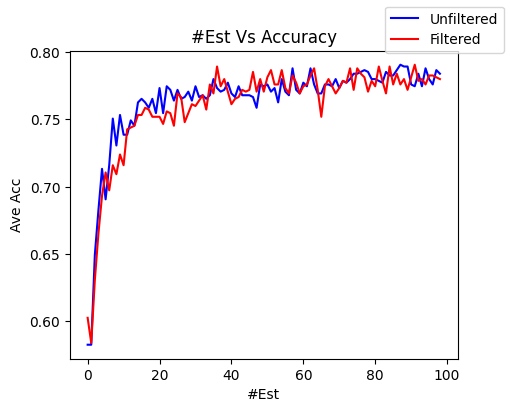

In [7]:
# Graph Accuracies
import pickle
try:
    with open('reacacc.pkl', 'rb') as file: 
        recacc = pickle.load(file)
        file.close()
    with open('reacacc_F.pkl', 'rb') as file: 
        recacc_F = pickle.load(file)
        file.close()
except:
    print("Failed")
    
fig4, ax4 = plt.subplots(1,1, figsize=(5, 4))  
ax4.plot(recacc,'b')
ax4.plot(recacc_F,'r')
fig4.legend(["Unfiltered", "Filtered"])
plt.title("#Est Vs Accuracy")
plt.xlabel("#Est")
plt.ylabel("Ave Acc")

In [ ]:
#Save classifier using ideal number of estimators

clf = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
clf.fit(X_train, Y_train)
acc = clf.predict(X_test)
for i in range(len(acc)):
    acc[i] = acc[i] == Y_test[i]
acc = sum(acc)/len(acc)
print(acc)


clf = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
clf.fit(X_train_F, Y_train_F)
acc = clf.predict(X_test_F)
for i in range(len(acc)):
    acc[i] = acc[i] == Y_test_F[i]
acc = sum(acc)/len(acc)
print(acc)

with open('./classifier.h', 'w') as file:
        file.write(port(clf, classname='RandomForestClassifier', tmp_file='./treeclf.json'))

0.7333333333333333
[0.09623114 0.09825343 0.14770525 0.11394378 0.09079857 0.08837931
 0.05441415 0.07531535 0.10839525 0.12656377]
0.8666666666666667
[0.09265573 0.11586575 0.13464308 0.11256479 0.10781286 0.06746825
 0.07570447 0.07905774 0.09499447 0.11923286]
